In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
pd.set_option("display.max_columns", 50)

### Load data

In [29]:
tournament = "kpl"

df = pd.read_csv("data/df_"+tournament+"2018_preprocessed_allMatches.csv")
# is_wicket column
df["is_bowler_wicket"] = df["dismissal_kind"].isin(["caught","bowled","lbw","caught and bowled","stumped"]).values.astype(int)
del df['Unnamed: 0']

dfbatimpint, dfbowlimpint = get_impact_period(df)

dfi_bat = get_bat_impact_score(dfbatimpint)
#Scaling impact score to 100
dfi_bat[[i for i in range(120)]] = dfi_bat[[i for i in range(120)]] / 14000 * 100
dfi_bat.to_json("code/data/impact_period/"+tournament+"_bat_impact.json", orient="records")

dfi_ball = get_ball_impact_score(dfbowlimpint)
dfi_ball[[i for i in range(120)]] = dfi_ball[[i for i in range(120)]] / 300 * 100
dfi_ball.to_json("code/data/impact_period/"+tournament+"_ball_impact.json", orient="records")

20


In [30]:
dfi_bat["team"].unique()

array(['Hubli Tigers', 'Bengaluru Blasters', 'Belagavi Panthers',
       'Mysuru Warriors', 'Shivamogga Lions', 'Bijapur Bulls',
       'Bellary Tuskers'], dtype=object)

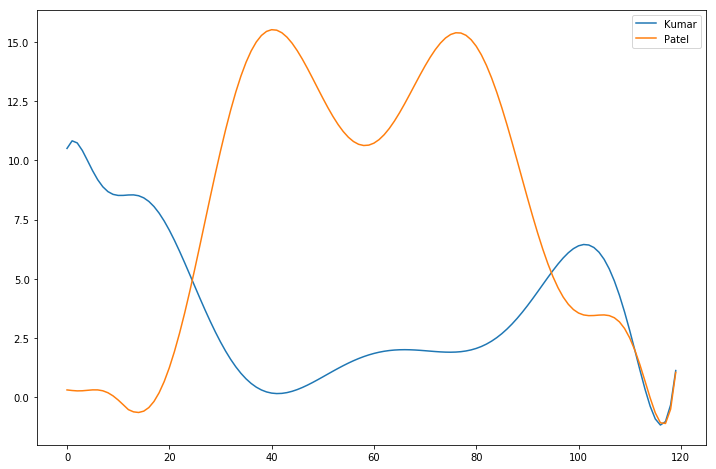

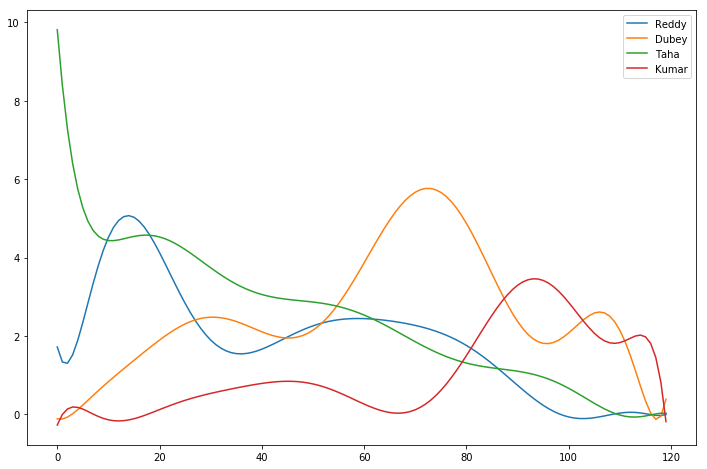

In [38]:
dfiball = dfi_ball.copy()
dfibat = dfi_bat.copy()

dfiball = dfiball[dfiball["wickets"]>=6]
dfibat = dfibat[dfibat["runs_scored"]>=100]

team = "Hubli Tigers"
plt.figure(figsize=(12,8))
bowler_list = dfiball[dfiball["team"]==team]["bowler"].values
for bowler in bowler_list:
    dft = dfiball[(dfiball["bowler"]==bowler) & (dfiball["team"]==team)]
    dfis = dft[[i for i in range(120)]] #* dft["bowl_venue"].values[0]
    plt.plot(range(120), np.asarray(dfis[[i for i in range(120)]]).T)
plt.legend(bowler_list)

plt.figure(figsize=(12,8))
batsman_list = dfibat[dfibat["team"]==team]["batsman"].values
for batsman in batsman_list:
    dft = dfibat[(dfibat["batsman"]==batsman) & (dfibat["team"]==team)]
    dfis = dft[[i for i in range(120)]] #* dft["bowl_venue"].values[0]
    plt.plot(range(120), np.asarray(dfis[[i for i in range(120)]]).T)
plt.legend(batsman_list)

In [ ]:
"""
dfit = dfiball[dfiball["wickets"]>=6].copy()
#del dfit["bowl_venue"], dfit["wickets"]
dfit = dfit.groupby("team").sum().reset_index()
plt.figure(figsize=(12,8))
#for t in dfit["batting_team"]:
plt.plot(range(120), np.asarray(dfit[[i for i in range(120)]]).T)
plt.legend(dfit["team"])
"""

In [3]:
def get_ball_correction_factor(x, num_balls_faced_arr):
    correction_factor_arr = []
    for i in range(len(num_balls_faced_arr)):
        """
        if num_balls_faced_arr[i]>=9:
            correction_factor_arr.append(x/24)
        else:
            correction_factor_arr.append(1)
        """
        correction_factor_arr.append(x/12)
    return correction_factor_arr
        
    
def get_ball_impact_score(dfbowlimpint):
    dfball_impact_period = dfbowlimpint.transpose().join(df[["bowler","bowling_team"]].drop_duplicates().set_index("bowler"))
    dfball_impact_period = dfball_impact_period.reset_index().rename(columns={"index":"bowler"})

    dfball_impact_score = pd.read_csv("data/"+tournament+"_ball_impact_score.csv")
    dfball_impact_score.rename(columns={"player": "bowler", "team":"bowling_team"}, inplace=True)
    dfball_impact_score.sort_values("bowl_venue", ascending=False)

    dfiball = dfball_impact_period.set_index(["bowler","bowling_team"]).join(dfball_impact_score[["bowler","bowling_team","bowl_venue", "wickets"]].set_index(["bowler","bowling_team"])).reset_index()

    dfbi = dfball_impact_period.copy()
    for col in range(12):
        initial_overs_mean = dfbi[[i for i in range(24)]].mean(axis=1)
        #dfbi[col] = initial_overs_mean + correction_factor*(dfbi[col] - initial_overs_mean)
        dfbi[col] = initial_overs_mean + get_ball_correction_factor(col, dfbi[col]) * (dfbi[col] - initial_overs_mean)

    dfic = dfbi.set_index(["bowler","bowling_team"]).join(dfball_impact_score[["bowler","bowling_team","bowl_venue","wickets"]].set_index(["bowler","bowling_team"])).reset_index()

    dfi_ball = pd.DataFrame()
    for bowler in dfic["bowler"]:
        dft = dfic[dfic["bowler"]==bowler]
        dfis = dft[[i for i in range(120)]] * dft["bowl_venue"].values[0]
        dfis.at[dfis.index, "bowler"] = bowler
        dfis.at[dfis.index, "team"] = dft["bowling_team"].values[0]
        dfis.at[dfis.index, "wickets"] = dft["wickets"].values[0]
        dfi_ball = dfi_ball.append(dfis)

    dfi_ball = dfi_ball.dropna()
    #dfi_ball.to_json("code/data/impact_period/bat_impact_initialBallsCorrected.json", orient="records")
    
    # Shorten player name
    for bowler_name in dfi_ball["bowler"]:
        if len(str.split(bowler_name, " "))==1 or bowler_name=="Rashid Khan" or bowler_name=="Kuldeep Yadav" or bowler_name=="Umesh Yadav":
            bowler_name_short = str.split(bowler_name, " ")[0]
        else:
            bowler_name_short  = str.split(bowler_name, " ")[1]
        dfi_ball.loc[dfi_ball["bowler"]==bowler_name, "bowler"] = bowler_name_short
    
    return dfi_ball

In [4]:
def get_correction_factor(x, num_balls_faced_arr):
    correction_factor_arr = []
    for i in range(len(num_balls_faced_arr)):
        if num_balls_faced_arr[i]>=9:
            correction_factor_arr.append(x/6)
        else:
            correction_factor_arr.append(1)
    return correction_factor_arr


def get_impact_period(df):
    dfbatimp = pd.DataFrame()
    dfbowlimp = pd.DataFrame()

    for m in df['match_id'].unique():

        if m%10==0:
            print(m)

        dfm = df[df['match_id']==m]

        for b in range(len(dfm)):  ### Ball by ball for first innings

            ballid = (dfm.iloc[b]["over"]-1)*6 + (dfm.iloc[b]["ball"]-1)

            batsman = dfm.iloc[b]["batsman"]
            bowler = dfm.iloc[b]["bowler"]

            if batsman not in dfbatimp:
                for i in range(120):
                    dfbatimp.at[i,batsman] = 0

            if bowler not in dfbowlimp:
                for i in range(120):
                    dfbowlimp.at[i,bowler] = 0

            dfbatimp.at[ballid,batsman] = dfbatimp.at[ballid,batsman] + 1 
            dfbowlimp.at[ballid,bowler] = dfbowlimp.at[ballid,bowler] + 1 

    dfbatimpint = dfbatimp.copy()
    for col in dfbatimpint.columns:
        dfbatimpint[col] = dfbatimpint[col] #/sum(dfbatimpint[col])

        x = range(len(dfbatimpint[col]))
        y = dfbatimpint[col] #/sum(dfbatimpint[col])

        p = np.poly1d(np.polyfit(x, y, 10))
        dfbatimpint[col] = p(x)
        
    dfbowlimpint = dfbowlimp.copy()
    for col in dfbowlimpint.columns:
        dfbowlimpint[col] = dfbowlimpint[col] #/sum(dfbatimpint[col])

        x = range(len(dfbowlimpint[col]))
        y = dfbowlimpint[col] #/sum(dfbatimpint[col])

        p = np.poly1d(np.polyfit(x, y, 10))
        dfbowlimpint[col] = p(x)

    return dfbatimpint, dfbowlimpint


def get_bat_impact_score(dfbatimpint):
    dfbat_impact_period = dfbatimpint.transpose().join(df[["batsman","batting_team"]].drop_duplicates().set_index("batsman"))
    dfbat_impact_period = dfbat_impact_period.reset_index().rename(columns={"index":"batsman"})

    dfbat_impact_score = pd.read_csv("data/"+tournament+"_bat_impact_score.csv")
    dfbat_impact_score.rename(columns={"player": "batsman", "team":"batting_team"}, inplace=True)

    dfi = dfbat_impact_period.set_index(["batsman","batting_team"]).join(dfbat_impact_score[["batsman","batting_team","bat_venue", "runs_scored"]].set_index(["batsman","batting_team"])).reset_index()

    ### Correction for first few balls
    dfbi = dfbat_impact_period.copy()        

    for col in range(6):
        initial_overs_mean = dfbi[[i for i in range(12)]].mean(axis=1)
        #dfbi[col] = initial_overs_mean + correction_factor*(dfbi[col] - initial_overs_mean)
        dfbi[col] = initial_overs_mean + get_correction_factor(col, dfbi[col]) * (dfbi[col] - initial_overs_mean)

    dfic = dfbi.set_index(["batsman","batting_team"]).join(dfbat_impact_score[["batsman","batting_team","bat_venue", "runs_scored"]].set_index(["batsman","batting_team"])).reset_index()
    dfic

    dfi_bat = pd.DataFrame()
    for batsman in dfic["batsman"]:
        dft = dfic[dfic["batsman"]==batsman]
        dfis = dft[[i for i in range(120)]] * dft["bat_venue"].values[0]
        dfis.at[dfis.index, "batsman"] = batsman
        dfis.at[dfis.index, "team"] = dft["batting_team"].values[0]
        dfis.at[dfis.index, "runs_scored"] = dft["runs_scored"].values[0]
        dfi_bat = dfi_bat.append(dfis)

    dfi_bat = dfi_bat.dropna()
    
    # Shorten player name
    for batsman_name in dfi_bat["batsman"]:
        if len(str.split(batsman_name, " "))==1:
            batsman_name_short = str.split(batsman_name, " ")[0]
        else:
            batsman_name_short  = str.split(batsman_name, " ")[1]
        dfi_bat.loc[dfi_bat["batsman"]==batsman_name, "batsman"] = batsman_name_short

    return dfi_bat

### Legacy

In [228]:
tournament = "ipl"
df = pd.read_csv("data/df_"+tournament+"2018_preprocessed_allMatches.csv")

In [229]:
dfbatimp = pd.DataFrame()
dfbowlimp = pd.DataFrame()

for m in df['match_id'].unique():
    
    if m%10==0:
        print(m)
        
    dfm = df[df['match_id']==m]

    for b in range(len(dfm)):  ### Ball by ball for first innings

        ballid = (dfm.iloc[b]["over"]-1)*6 + (dfm.iloc[b]["ball"]-1)

        batsman = dfm.iloc[b]["batsman"]
        bowler = dfm.iloc[b]["bowler"]

        if batsman not in dfbatimp:
            for i in range(120):
                dfbatimp.at[i,batsman] = 0

        if bowler not in dfbowlimp:
            for i in range(120):
                dfbowlimp.at[i,bowler] = 0

        dfbatimp.at[ballid,batsman] = dfbatimp.at[ballid,batsman] + 1 
        dfbowlimp.at[ballid,bowler] = dfbowlimp.at[ballid,bowler] + 1 


640
650
660
670
680
690


In [230]:
dfbatimpint = dfbatimp.copy()
for col in dfbatimpint.columns:
    dfbatimpint[col] = dfbatimpint[col] #/sum(dfbatimpint[col])
    
    x = range(len(dfbatimpint[col]))
    y = dfbatimpint[col] #/sum(dfbatimpint[col])

    p = np.poly1d(np.polyfit(x, y, 10))
    dfbatimpint[col] = p(x)
    
dfbowlimpint = dfbowlimp.copy()
for col in dfbowlimpint.columns:
    dfbowlimpint[col] = dfbowlimpint[col] #/sum(dfbatimpint[col])
    
    x = range(len(dfbowlimpint[col]))
    y = dfbowlimpint[col] #/sum(dfbatimpint[col])

    p = np.poly1d(np.polyfit(x, y, 10))
    dfbowlimpint[col] = p(x)

In [231]:
dfbat_impact_period = dfbatimpint.transpose().join(df[["batsman","batting_team"]].drop_duplicates().set_index("batsman"))
dfbat_impact_period = dfbat_impact_period.reset_index().rename(columns={"index":"batsman"})

dfball_impact_period = dfbowlimpint.transpose().join(df[["bowler","bowling_team"]].drop_duplicates().set_index("bowler"))
dfball_impact_period = dfball_impact_period.reset_index().rename(columns={"index":"bowler"})

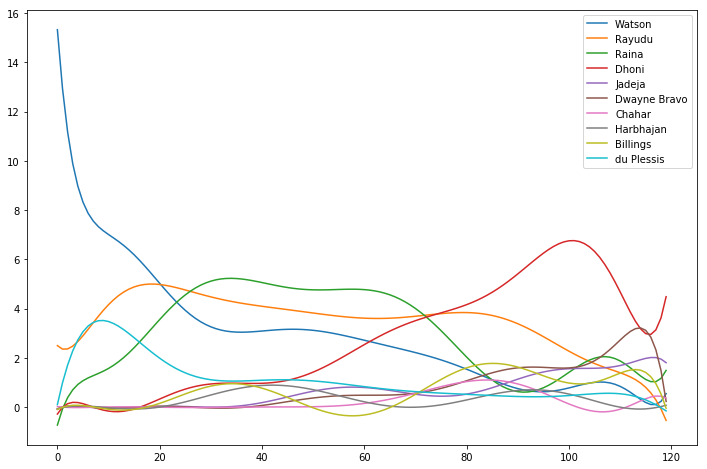

In [8]:
team = "Chennai Super Kings"
leg = []
plt.figure(figsize=(12,8))
for col in dfbat_impact_period[dfbat_impact_period["batting_team"] == team]["batsman"]:
    x = range(len(dfbatimpint[col]))
    y = dfbatimpint[col] #/sum(dfbatimpint[col])
    
    #print(sum(dfbatimpint[col]))
    if sum(dfbatimpint[col]) > 30:
        leg.append(col)
        plt.plot(x,y)
plt.legend(leg)

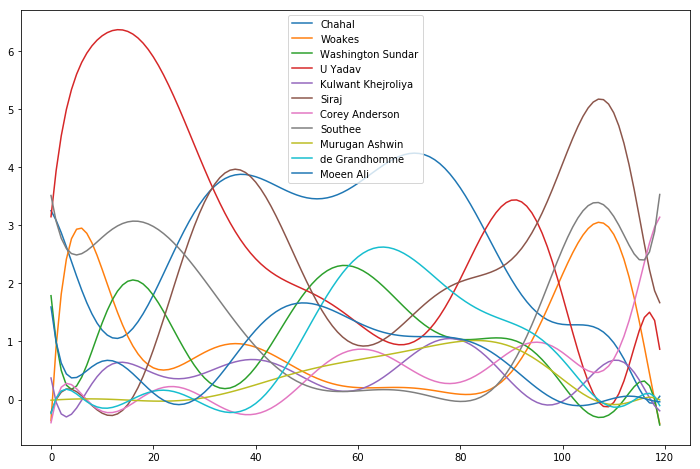

In [234]:
team = "Royal Challengers Bangalore"
leg = []
plt.figure(figsize=(12,8))
for col in dfball_impact_period[dfball_impact_period["bowling_team"] == team]["bowler"]:
    x = range(len(dfbowlimpint[col]))
    y = dfbowlimpint[col] #/sum(dfbatimpint[col])
    
    #print(sum(dfbatimpint[col]))
    if sum(dfbowlimpint[col]) > 30:
        leg.append(col)
        plt.plot(x,y)
plt.legend(leg)

### Scale impact period with impact score

In [282]:
dfbat_impact_score = pd.read_csv("data/"+tournament+"_bat_impact_score.csv")
dfbat_impact_score.rename(columns={"player": "batsman", "team":"batting_team"}, inplace=True)
dfbat_impact_score

dfball_impact_score = pd.read_csv("data/"+tournament+"_ball_impact_score.csv")
dfball_impact_score.rename(columns={"player": "bowler", "team":"bowling_team"}, inplace=True)
dfball_impact_score.sort_values("bowl_venue", ascending=False)

,season,bowling_team,bowler,wickets,zs_bowl_avg,zs_bowl_econ,bowl_venue
26,2018,Kings XI Punjab,Andrew Tye,24.0,3.788434,2.308515,30.096949
76,2018,Royal Challengers Bangalore,U Yadav,20.0,1.798460,2.429266,24.227726
45,2018,Mumbai Indians,Bumrah,17.0,1.682735,5.536982,24.219717
87,2018,Sunrisers Hyderabad,Rashid Khan,21.0,0.076762,2.200880,23.277642
31,2018,Kings XI Punjab,Mujeeb,14.0,0.682305,5.160632,19.842937
49,2018,Mumbai Indians,Hardik Pandya,18.0,1.521099,-0.712049,18.809050
88,2018,Sunrisers Hyderabad,S Kaul,21.0,0.583791,-3.562140,18.021651
50,2018,Mumbai Indians,Krunal Pandya,11.0,1.192859,5.223219,17.416079
38,2018,Kolkata Knight Riders,Narine,17.0,0.281081,-1.172594,16.108487
67,2018,Royal Challengers Bangalore,Chahal,12.0,1.680344,2.164304,15.844647


In [283]:
dfi = dfbat_impact_period.set_index(["batsman","batting_team"]).join(dfbat_impact_score[["batsman","batting_team","bat_venue", "runs_scored"]].set_index(["batsman","batting_team"])).reset_index()
dfiball = dfball_impact_period.set_index(["bowler","bowling_team"]).join(dfball_impact_score[["bowler","bowling_team","bowl_venue", "wickets"]].set_index(["bowler","bowling_team"])).reset_index()
dfiball

,bowler,bowling_team,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,...,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,bowl_venue,wickets
0,Chahar,Chennai Super Kings,16.612397,13.680010,11.307946,9.416649,7.934620,6.797878,5.949447,5.338843,4.921589,4.658747,4.516462,4.465531,4.480991,4.541721,4.630071,4.731511,4.834290,4.929133,5.008938,5.068510,5.104301,5.114179,5.097209,...,0.041948,0.042349,0.039826,0.034506,0.026690,0.016856,0.005650,-0.006125,-0.017539,-0.027577,-0.035195,-0.039400,-0.039347,-0.034461,-0.024592,-0.010195,0.007453,0.025992,0.041685,0.049067,0.040542,0.005932,-0.068049,11.467932,10.0
1,Watson,Chennai Super Kings,0.207180,-0.018614,-0.098639,-0.071698,0.031010,0.184717,0.370052,0.572130,0.779768,0.984804,1.181505,1.366066,1.536187,1.690717,1.829349,1.952384,2.060533,2.154753,2.236132,2.305795,2.364834,2.414267,2.455004,...,0.843758,0.918462,0.996752,1.074523,1.147139,1.209542,1.256391,1.282271,1.281935,1.250631,1.184489,1.080996,0.939559,0.762178,0.554223,0.325345,0.090526,-0.128727,-0.303006,-0.393455,-0.350016,-0.109454,0.406842,1.601044,6.0
2,Harbhajan,Chennai Super Kings,-0.064151,-0.094819,0.083910,0.384679,0.741035,1.104022,1.439177,1.723884,1.945065,2.097173,2.180463,2.199511,2.161954,2.077442,1.956760,1.811118,1.651582,1.488628,1.331812,1.189525,1.068844,0.975440,0.913552,...,-0.179643,-0.209565,-0.223125,-0.220621,-0.203033,-0.172068,-0.130163,-0.080464,-0.026753,0.026673,0.075188,0.114101,0.138997,0.146193,0.133291,0.099874,0.048343,-0.015078,-0.079153,-0.126242,-0.130672,-0.056862,0.142835,1.948796,7.0
3,Jadeja,Chennai Super Kings,0.515373,-0.098505,-0.386281,-0.450426,-0.370494,-0.206882,-0.004116,0.206257,0.403165,0.573841,0.711967,0.816090,0.888287,0.933056,0.956402,0.965096,0.966091,0.966070,0.971108,0.986441,1.016310,1.063883,1.131234,...,0.673970,0.629374,0.608753,0.609334,0.627130,0.656977,0.692638,0.726988,0.752281,0.760543,0.744071,0.696092,0.611580,0.488258,0.327819,0.137378,-0.068814,-0.267352,-0.423343,-0.487703,-0.394064,-0.055241,0.640778,11.372809,11.0
4,Mark Wood,Chennai Super Kings,0.043955,0.008945,-0.013486,-0.025878,-0.030494,-0.029328,-0.024110,-0.016316,-0.007186,0.002263,0.011225,0.019081,0.025386,0.029846,0.032308,0.032732,0.031181,0.027800,0.022804,0.016456,0.009061,0.000945,-0.007549,...,0.476403,0.492424,0.508080,0.523313,0.538054,0.552209,0.565634,0.578121,0.589358,0.598903,0.606135,0.610204,0.609975,0.603954,0.590211,0.566286,0.529084,0.474754,0.398555,0.294700,0.156189,-0.025389,-0.260064,-1.510816,0.0
5,Tahir,Chennai Super Kings,-0.244932,0.035669,0.163064,0.189147,0.153732,0.086599,0.009282,-0.063377,-0.121876,-0.160897,-0.178319,-0.174384,-0.151000,-0.111164,-0.058496,0.003133,0.069894,0.138216,0.204945,0.267444,0.323657,0.372130,0.412004,...,1.357064,1.206752,1.045720,0.877813,0.707689,0.540748,0.383008,0.240924,0.121136,0.030134,-0.026164,-0.042947,-0.017155,0.051732,0.160763,0.302408,0.463274,0.622605,0.750559,0.806229,0.735396,0.467973,-0.084877,3.862471,6.0
6,Dwayne Bravo,Chennai Super Kings,0.228361,-0.017171,-0.135817,-0.168910,-0.148378,-0.098317,-0.036366,0.025097,0.077920,0.117291,0.140977,0.148689,0.141537,0.121597,0.091541,0.054349,0.013085,-0.029285,-0.070013,-0.106664,-0.137165,-0.159842,-0.173420,...,5.567235,5.810693,6.047212,6.269467,6.469697,6.639957,6.772456,6.859976,6.896398,6.877330,6.800868,6.668493,6.486129,6.265368,6.024888,5.792085,5.604935,5.514105,5.585347,5.902190,6.568964,7.714173,9.494262,4.428797,14.0
7,McClenaghan,Mumbai Indians,7.243019,7.273530,7.036784,6.638602,6.159899,5.660739,5.183905,4.758038,4.400380,4.119153,3.915606,3.785773,3.721957,3.713978,3.750201,3.818385,3.906344,4.002481,4.096178,4.178076,4.240264,4.276380,4.281649,...,2.366277,2.283899,2.175672,2.043355,1.889894,1.719488,1.537617,1.351021,1.167627,0.996399,0.847111,0.730017,0.655415,0.633078,0.671529,0.777163,0.953164,1.198214,1.504964,1.858236,2.232928,2.591597,2.881678,14.280780,14.0
8,Mustafizur,Mumbai India

### Save bat impact data

In [87]:
import json

In [200]:
dfi_bat = pd.DataFrame()

for batsman in dfi["batsman"]:
    dft = dfi[dfi["batsman"]==batsman]
    dfis = dft[[i for i in range(120)]] * dft["bat_venue"].values[0]
    dfis.at[dfis.index, "batsman"] = batsman
    dfis.at[dfis.index, "team"] = dft["batting_team"].values[0]
    dfis.at[dfis.index, "runs_scored"] = dft["runs_scored"].values[0]
    dfi_bat = dfi_bat.append(dfis)

dfi_bat = dfi_bat.dropna()
#dfi_bat.to_json("code/data/impact_period/bat_impact.json", orient="records")
dfi_bat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,batsman,team,runs_scored
0,1030.259791,1127.210728,1176.962751,1190.921114,1178.497142,1147.374366,1103.747709,1052.537731,997.581852,941.804357,887.366900,835.801113,788.124848,744.943486,706.537658,672.938643,643.992630,619.414952,598.835329,581.835081,567.977217,556.830222,547.986327,541.074955,535.772021,...,1283.030590,1274.030502,1263.360425,1250.688497,1235.674258,1217.975145,1197.253414,1173.183395,1145.458878,1113.800493,1077.962832,1037.741098,992.976982,943.563461,889.448164,830.634907,767.182964,699.203584,626.853236,550.322983,469.823368,385.564106,Rohit,Mumbai Indians,262.0
1,503.778848,1614.295982,2426.650124,3005.188519,3403.003270,3663.498218,3821.785923,3905.928624,3938.036235,3935.233676,3910.509085,3873.453739,3830.903811,3787.493457,3746.128063,3708.385883,3674.855726,3645.417784,3619.474160,3596.135150,3574.366868,3553.105297,3531.341466,3508.182008,3482.888961,...,224.078658,194.975553,161.362135,124.198471,84.775442,44.694503,5.827029,-29.750733,-59.851443,-82.303977,-95.119503,-96.701987,-86.109366,-63.372038,-29.875961,11.181867,54.257121,90.832055,108.689927,91.079620,15.759412,-146.091849,Lewis,Mumbai Indians,354.0
2,61.046456,228.877093,343.251626,419.510966,469.941262,504.201904,529.710367,551.987042,574.963013,601.253598,632.400317,669.083819,711.310147,758.572616,809.991399,864.432861,920.610497,977.169253,1032.754900,1086.069989,1135.917865,1181.236065,1221.120382,1254.840747,1281.850013,...,77.683683,27.043332,-16.022058,-51.097634,-77.898750,-96.289713,-106.303894,-108.165419,-102.312673,-89.423877,-70.445061,-46.620765,-19.527877,8.886976,36.265989,59.794159,76.148096,81.439017,71.149216,40.061248,-17.821033,-109.360469,Ishan Kishan,Mumbai Indians,261.0
3,11751.495057,9854.966797,8416.562963,7346.098633,6567.747336,6018.209555,5645.064677,5405.292435,5263.950626,5192.996651,5170.241107,5178.422380,5204.391801,5238.399609,5273.472535,5304.874426,5329.641901,5346.187523,5353.963562,5353.179825,5344.569597,5329.198108,5308.308416,5283.199991,5255.135681,...,482.298714,465.044332,453.558909,447.076282,444.582570,444.820564,446.306672,447.363199,446.168971,440.831694,429.485733,410.419386,382.236065,344.054233,295.751330,238.257373,173.904361,106.838107,43.499604,-6.816430,-31.317649,-12.976070,Suryakumar Yadav,Mumbai Indians,491.0
4,162.299083,-0.838010,-84.168448,-112.575200,-105.483433,-77.739209,-40.383134,-1.328140,34.049975,62.401153,81.961273,92.176857,93.387705,86.561305,73.073349,54.529035,32.620320,9.014587,-14.729385,-37.221947,-57.283069,-73.965924,-86.566446,-94.621420,-97.897416,...,1852.953032,1867.484135,1880.203226,1889.905136,1895.197624,1894.544489,1886.328907,1868.940421,1840.889417,1800.953195,1748.358161,1683.003015,1605.728223,1518.637479,1425.477293,1332.081310,1246.886436,1181.528337,1151.524415,1177.052886,1283.837156,1504.145271,Hardik Pandya,Mumbai Indians,224.0
5,83.293305,-5.656901,-49.070349,-61.466641,-54.203666,-35.968679,-13.213599,9.460851,28.967816,43.439700,51.972442,54.405060,51.131110,42.938873,30.877373,16.145437,0.001294,-16.309680,-31.611231,-44.838542,-55.068438,-61.539179,-63.661408,-61.021653,-53.379681,...,1393.866812,1408.090192,1415.347572,1414.743325,1405.375798,1386.364337,1356.884477,1316.212661,1263.781963,1199.250423,1122.583779,1034.154495,934.859190,826.256687,710.729152,591.668903,473.693724,362.893685,267.112704,196.268295,162.713180,181.642688,Krunal Pandya,Mumbai Indians,194.0
6,15871.875200,13398.726323,11570.694840,10241.722206,9291.633203,8622.580045,8155.862379,7829.093347,7593.683530,7412.616244,7258.489221,7111.799223,6959.447583,6793.446062,6609.803760,6407.577097,6188.066107,5954.141468,5709.687836,5459.150090,5207.170159,4958.303056,4716.801688,4486.460882,4270.511934,...,715.437664,758.590915,808.644867,862.705348,917.328611,968.587326,1012.177628,1043.574895,1058.246708,1051

In [239]:
dfi_ball = pd.DataFrame()

for batsman in dfiball["bowler"]:
    dft = dfiball[dfiball["bowler"]==batsman]
    dfis = dft[[i for i in range(120)]] * dft["bowl_venue"].values[0]
    dfis.at[dfis.index, "bowler"] = batsman
    dfis.at[dfis.index, "team"] = dft["bowling_team"].values[0]
    dfis.at[dfis.index, "wickets"] = dft["wickets"].values[0]
    dfi_ball = dfi_ball.append(dfis)

dfi_ball = dfi_ball.dropna()
dfi_ball

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,bowler,team,wickets
0,190.509848,156.881434,129.678764,107.989498,90.993681,77.957610,68.227858,61.225487,56.440449,53.426193,51.794478,51.210412,51.387703,52.084147,53.097345,54.260643,55.439314,56.526963,57.442165,58.125327,58.535775,58.649054,58.454446,57.952691,57.153913,...,0.485654,0.456719,0.395713,0.306085,0.193304,0.064795,-0.070239,-0.201135,-0.316247,-0.403613,-0.451838,-0.451226,-0.395197,-0.282020,-0.116913,0.085467,0.298077,0.478046,0.562692,0.464933,0.068031,-0.780380,Chahar,Chennai Super Kings,10.0
1,0.331705,-0.029802,-0.157925,-0.114792,0.049648,0.295741,0.592469,0.916005,1.248444,1.576715,1.891641,2.187132,2.459504,2.706912,2.928868,3.125854,3.299004,3.449855,3.580147,3.691680,3.786204,3.865348,3.930570,3.983142,4.024139,...,1.470498,1.595844,1.720359,1.836621,1.936530,2.011538,2.052972,2.052435,2.002316,1.896420,1.730722,1.504276,1.220280,0.887335,0.520893,0.144936,-0.206097,-0.485126,-0.629939,-0.560390,-0.175241,0.651371,Watson,Chennai Super Kings,6.0
2,-0.125018,-0.184783,0.163524,0.749662,1.444125,2.151513,2.804662,3.359498,3.790534,4.086961,4.249277,4.286397,4.213207,4.048510,3.813326,3.529499,3.218596,2.901032,2.595428,2.318140,2.082958,1.900932,1.780327,1.726653,1.742789,...,-0.408399,-0.434825,-0.429945,-0.395670,-0.335326,-0.253661,-0.156807,-0.052135,0.051980,0.146527,0.222359,0.270877,0.284900,0.259756,0.194633,0.094210,-0.029384,-0.154254,-0.246021,-0.254654,-0.110813,0.278357,Harbhajan,Chennai Super Kings,7.0
3,5.861234,-1.120281,-4.393105,-5.122605,-4.213563,-2.352828,-0.046810,2.345721,4.585113,6.526183,8.097070,9.281239,10.102322,10.611473,10.876980,10.975854,10.987170,10.986925,11.044227,11.218607,11.558299,12.099337,12.865308,13.867659,15.106428,...,7.157746,6.923228,6.929841,7.132231,7.471673,7.877244,8.267891,8.555553,8.649511,8.462179,7.916526,6.955379,5.552863,3.728226,1.562372,-0.782608,-3.040545,-4.814596,-5.546551,-4.481616,-0.628246,7.287448,Jadeja,Chennai Super Kings,11.0
4,-0.066408,-0.013514,0.020375,0.039097,0.046071,0.044310,0.036425,0.024650,0.010857,-0.003419,-0.016959,-0.028828,-0.038353,-0.045092,-0.048811,-0.049452,-0.047109,-0.042001,-0.034452,-0.024862,-0.013689,-0.001428,0.011405,0.024294,0.036731,...,-0.743962,-0.767615,-0.790629,-0.812901,-0.834286,-0.854569,-0.873434,-0.890412,-0.904833,-0.915758,-0.921906,-0.921559,-0.912463,-0.891700,-0.855554,-0.799349,-0.717266,-0.602143,-0.445238,-0.235973,0.038357,0.392909,Mark Wood,Chennai Super Kings,0.0
5,-0.946041,0.137771,0.629831,0.730575,0.593786,0.334487,0.035850,-0.244793,-0.470742,-0.621459,-0.688751,-0.673553,-0.583231,-0.429366,-0.225939,0.012101,0.269963,0.533857,0.791594,1.032996,1.250117,1.437342,1.591354,1.711019,1.797199,...,4.661045,4.039064,3.390527,2.733428,2.088622,1.479356,0.930562,0.467885,0.116393,-0.101059,-0.165882,-0.066261,0.199815,0.620942,1.168042,1.789383,2.404794,2.899011,3.114035,2.840445,1.807530,-0.327837,Tahir,Chennai Super Kings,6.0
6,1.011364,-0.076045,-0.601506,-0.748068,-0.657135,-0.435424,-0.161056,0.111148,0.345091,0.519456,0.624360,0.658512,0.626840,0.538529,0.405416,0.240703,0.057949,-0.129698,-0.310075,-0.472391,-0.607476,-0.707907,-0.768041,-0.783963,-0.753380,...,25.734380,26.781871,27.766195,28.652973,29.407020,29.993830,30.381441,30.542746,30.458296,30.119660,29.533400,28.725748,27.748040,26.683003,25.651968,24.823118,24.420850,24.736366,26.139601,29.092606,34.164503,42.048158,Dwayne Bravo,Chennai Super Kings,14.0
7,103.435968,103.871678,100.490765,94.804414,87.968171,80.839775,74.030204,67.948490,62.840862,58.824717,55.917908,54.063793,53.152452,53.038499,53.555804,54.529512,55.785640,57.158557,58.496617,59.666182,60.554273,61.070048,61.145296,60.734128,59.812007,...,32.615867,31.070297,29.180703,26.989161,24.555633,21.958367,19.293635,16.674625,14.229358,12.097401,10.425209,9.359844,9.040842,9.589956,11.098492,13.611919,17.

### Correcting impact period of initial few balls

In [306]:
dfbi = dfbat_impact_period.copy()

def get_correction_factor(x, num_balls_faced_arr):
    correction_factor_arr = []
    for i in range(len(num_balls_faced_arr)):
        if num_balls_faced_arr[i]>=9:
            correction_factor_arr.append(x/6)
        else:
            correction_factor_arr.append(1)
        
    return correction_factor_arr
        

for col in range(6):
    initial_overs_mean = dfbi[[i for i in range(12)]].mean(axis=1)
    #dfbi[col] = initial_overs_mean + correction_factor*(dfbi[col] - initial_overs_mean)
    dfbi[col] = initial_overs_mean + get_correction_factor(col, dfbi[col]) * (dfbi[col] - initial_overs_mean)
    
dfic = dfbi.set_index(["batsman","batting_team"]).join(dfbat_impact_score[["batsman","batting_team","bat_venue", "runs_scored"]].set_index(["batsman","batting_team"])).reset_index()
dfic

dfi_bat = pd.DataFrame()
for batsman in dfic["batsman"]:
    dft = dfic[dfic["batsman"]==batsman]
    dfis = dft[[i for i in range(120)]] * dft["bat_venue"].values[0]
    dfis.at[dfis.index, "batsman"] = batsman
    dfis.at[dfis.index, "team"] = dft["batting_team"].values[0]
    dfis.at[dfis.index, "runs_scored"] = dft["runs_scored"].values[0]
    dfi_bat = dfi_bat.append(dfis)

dfi_bat = dfi_bat.dropna()
#dfi_bat.to_json("code/data/impact_period/bat_impact_initialBallsCorrected.json", orient="records")
dfi_bat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,batsman,team,runs_scored
0,843.356538,859.872387,883.185295,906.872086,926.401515,938.818321,942.453795,936.663386,921.591636,897.964504,866.908798,829.798176,788.124848,744.943486,706.537658,672.938643,643.992630,619.414952,598.835329,581.835081,567.977217,556.830222,547.986327,541.074955,535.772021,...,1283.030590,1274.030502,1263.360425,1250.688497,1235.674258,1217.975145,1197.253414,1173.183395,1145.458878,1113.800493,1077.962832,1037.741098,992.976982,943.563461,889.448164,830.634907,767.182964,699.203584,626.853236,550.322983,469.823368,385.564106,Rohit,Mumbai Indians,262.0
1,3407.381330,3368.859034,3405.667988,3482.995108,3575.782809,3666.924431,3745.650204,3806.100932,3846.085049,3866.013101,3868.002102,3855.140599,3830.903811,3787.493457,3746.128063,3708.385883,3674.855726,3645.417784,3619.474160,3596.135150,3574.366868,3553.105297,3531.341466,3508.182008,3482.888961,...,224.078658,194.975553,161.362135,124.198471,84.775442,44.694503,5.827029,-29.750733,-59.851443,-82.303977,-95.119503,-96.701987,-86.109366,-63.372038,-29.875961,11.181867,54.257121,90.832055,108.689927,91.079620,15.759412,-146.091849,Lewis,Mumbai Indians,354.0
2,730.843924,714.595897,706.367301,700.467933,693.864951,685.592347,676.212626,667.333752,661.183761,660.244646,666.946223,683.419764,711.310147,758.572616,809.991399,864.432861,920.610497,977.169253,1032.754900,1086.069989,1135.917865,1181.236065,1221.120382,1254.840747,1281.850013,...,77.683683,27.043332,-16.022058,-51.097634,-77.898750,-96.289713,-106.303894,-108.165419,-102.312673,-89.423877,-70.445061,-46.620765,-19.527877,8.886976,36.265989,59.794159,76.148096,81.439017,71.149216,40.061248,-17.821033,-109.360469,Ishan Kishan,Mumbai Indians,261.0
3,6061.684813,6160.472504,6128.320597,6018.021177,5869.243866,5710.605210,5561.567825,5434.167227,5334.565435,5264.431822,5222.153223,5203.876915,5204.391801,5238.399609,5273.472535,5304.874426,5329.641901,5346.187523,5353.963562,5353.179825,5344.569597,5329.198108,5308.308416,5283.199991,5255.135681,...,482.298714,465.044332,453.558909,447.076282,444.582570,444.820564,446.306672,447.363199,446.168971,440.831694,429.485733,410.419386,382.236065,344.054233,295.751330,238.257373,173.904361,106.838107,43.499604,-6.816430,-31.317649,-12.976070,Suryakumar Yadav,Mumbai Indians,491.0
4,-0.201213,-6.460888,-20.033363,-31.544338,-35.932987,-31.376237,-18.355587,1.137658,24.264156,47.872058,68.914293,84.756767,93.387705,86.561305,73.073349,54.529035,32.620320,9.014587,-14.729385,-37.221947,-57.283069,-73.965924,-86.566446,-94.621420,-97.897416,...,1852.953032,1867.484135,1880.203226,1889.905136,1895.197624,1894.544489,1886.328907,1868.940421,1840.889417,1800.953195,1748.358161,1683.003015,1605.728223,1518.637479,1425.477293,1332.081310,1246.886436,1181.528337,1151.524415,1177.052886,1283.837156,1504.145271,Hardik Pandya,Mumbai Indians,224.0
5,-5.874863,-9.262428,-16.295419,-21.647769,-22.545016,-18.134955,-8.933554,3.654174,17.739504,31.283534,42.361789,49.363646,51.131110,42.938873,30.877373,16.145437,0.001294,-16.309680,-31.611231,-44.838542,-55.068438,-61.539179,-63.661408,-61.021653,-53.379681,...,1393.866812,1408.090192,1415.347572,1414.743325,1405.375798,1386.364337,1356.884477,1316.212661,1263.781963,1199.250423,1122.583779,1034.154495,934.859190,826.256687,710.729152,591.668903,473.693724,362.893685,267.112704,196.268295,162.713180,181.642688,Krunal Pandya,Mumbai Indians,194.0
6,7658.701315,7823.339118,7831.930753,7756.727626,7647.114173,7533.935954,7433.417620,7350.667368,7282.767880,7221.457623,7155.410487,7072.126110,6959.447583,6793.446062,6609.803760,6407.577097,6188.066107,5954.141468,5709.687836,5459.150090,5207.170159,4958.303056,4716.801688,4486.460882,4270.511934,...,715.437664,758.590915,808.644867,862.705348,917.328611,968.587326,1012.177628,1043.574895,1058.246708,1051.932258,1020.998

In [317]:
dfbi = dfball_impact_period.copy()

def get_ball_correction_factor(x, num_balls_faced_arr):
    correction_factor_arr = []
    for i in range(len(num_balls_faced_arr)):
        """
        if num_balls_faced_arr[i]>=9:
            correction_factor_arr.append(x/24)
        else:
            correction_factor_arr.append(1)
        """
        correction_factor_arr.append(x/12)
    return correction_factor_arr
        

for col in range(12):
    initial_overs_mean = dfbi[[i for i in range(24)]].mean(axis=1)
    #dfbi[col] = initial_overs_mean + correction_factor*(dfbi[col] - initial_overs_mean)
    dfbi[col] = initial_overs_mean + get_ball_correction_factor(col, dfbi[col]) * (dfbi[col] - initial_overs_mean)
    
dfic = dfbi.set_index(["bowler","bowling_team"]).join(dfball_impact_score[["bowler","bowling_team","bowl_venue","wickets"]].set_index(["bowler","bowling_team"])).reset_index()
dfic

dfi_ball = pd.DataFrame()
for bowler in dfic["bowler"]:
    dft = dfic[dfic["bowler"]==bowler]
    dfis = dft[[i for i in range(120)]] * dft["bowl_venue"].values[0]
    dfis.at[dfis.index, "bowler"] = bowler
    dfis.at[dfis.index, "team"] = dft["bowling_team"].values[0]
    dfis.at[dfis.index, "wickets"] = dft["wickets"].values[0]
    dfi_ball = dfi_ball.append(dfis)

dfi_ball = dfi_ball.dropna()
#dfi_ball.to_json("code/data/impact_period/bat_impact_initialBallsCorrected.json", orient="records")
dfi_ball

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,bowler,team,wickets
0,73.678804,76.150059,76.152324,74.409950,71.542974,68.069856,64.411521,60.896605,57.767788,55.189088,53.253936,51.993881,51.387703,52.084147,53.097345,54.260643,55.439314,56.526963,57.442165,58.125327,58.535775,58.649054,58.454446,57.952691,57.153913,...,0.485654,0.456719,0.395713,0.306085,0.193304,0.064795,-0.070239,-0.201135,-0.316247,-0.403613,-0.451838,-0.451226,-0.395197,-0.282020,-0.116913,0.085467,0.298077,0.478046,0.562692,0.464933,0.068031,-0.780380,Chahar,Chennai Super Kings,10.0
1,2.066420,1.957991,1.824949,1.699410,1.603040,1.549160,1.544578,1.591152,1.687125,1.828228,2.008576,2.221381,2.459504,2.706912,2.928868,3.125854,3.299004,3.449855,3.580147,3.691680,3.786204,3.865348,3.930570,3.983142,4.024139,...,1.470498,1.595844,1.720359,1.836621,1.936530,2.011538,2.052972,2.052435,2.002316,1.896420,1.730722,1.504276,1.220280,0.887335,0.520893,0.144936,-0.206097,-0.485126,-0.629939,-0.560390,-0.175241,0.651371,Watson,Chennai Super Kings,6.0
2,2.537707,2.412534,2.324650,2.322607,2.423016,2.619192,2.888699,3.199806,3.516883,3.804766,4.032135,4.173978,4.213207,4.048510,3.813326,3.529499,3.218596,2.901032,2.595428,2.318140,2.082958,1.900932,1.780327,1.726653,1.742789,...,-0.408399,-0.434825,-0.429945,-0.395670,-0.335326,-0.253661,-0.156807,-0.052135,0.051980,0.146527,0.222359,0.270877,0.284900,0.259756,0.194633,0.094210,-0.029384,-0.154254,-0.246021,-0.254654,-0.110813,0.278357,Harbhajan,Chennai Super Kings,7.0
3,6.526731,5.914898,4.974142,4.147769,3.678252,3.658896,4.078332,4.858068,5.883421,7.028171,8.173400,9.220988,10.102322,10.611473,10.876980,10.975854,10.987170,10.986925,11.044227,11.218607,11.558299,12.099337,12.865308,13.867659,15.106428,...,7.157746,6.923228,6.929841,7.132231,7.471673,7.877244,8.267891,8.555553,8.649511,8.462179,7.916526,6.955379,5.552863,3.728226,1.562372,-0.782608,-3.040545,-4.814596,-5.546551,-4.481616,-0.628246,7.287448,Jadeja,Chennai Super Kings,11.0
4,-0.009037,-0.007219,-0.001925,0.004289,0.009514,0.012461,0.012405,0.009123,0.002818,-0.005964,-0.016416,-0.027566,-0.038353,-0.045092,-0.048811,-0.049452,-0.047109,-0.042001,-0.034452,-0.024862,-0.013689,-0.001428,0.011405,0.024294,0.036731,...,-0.743962,-0.767615,-0.790629,-0.812901,-0.834286,-0.854569,-0.873434,-0.890412,-0.904833,-0.915758,-0.921906,-0.921559,-0.912463,-0.891700,-0.855554,-0.799349,-0.717266,-0.602143,-0.445238,-0.235973,0.038357,0.392909,Mark Wood,Chennai Super Kings,0.0
5,0.258699,0.294636,0.367832,0.411030,0.392063,0.304334,0.158695,-0.023355,-0.215200,-0.389461,-0.521259,-0.590492,-0.583231,-0.429366,-0.225939,0.012101,0.269963,0.533857,0.791594,1.032996,1.250117,1.437342,1.591354,1.711019,1.797199,...,4.661045,4.039064,3.390527,2.733428,2.088622,1.479356,0.930562,0.467885,0.116393,-0.101059,-0.165882,-0.066261,0.199815,0.620942,1.168042,1.789383,2.404794,2.899011,3.114035,2.840445,1.807530,-0.327837,Tahir,Chennai Super Kings,6.0
6,-0.054976,-0.097460,-0.183833,-0.249189,-0.260451,-0.208015,-0.098581,0.050877,0.218056,0.379265,0.512442,0.599318,0.626840,0.538529,0.405416,0.240703,0.057949,-0.129698,-0.310075,-0.472391,-0.607476,-0.707907,-0.768041,-0.783963,-0.753380,...,25.734380,26.781871,27.766195,28.652973,29.407020,29.993830,30.381441,30.542746,30.458296,30.119660,29.533400,28.725748,27.748040,26.683003,25.651968,24.823118,24.420850,24.736366,26.139601,29.092606,34.164503,42.048158,Dwayne Bravo,Chennai Super Kings,14.0
7,68.080156,69.712388,71.068206,71.669419,71.318587,70.024943,67.939825,65.301486,62.389037,59.485178,56.847271,54.686210,53.152452,53.038499,53.555804,54.529512,55.785640,57.158557,58.496617,59.666182,60.554273,61.070048,61.145296,60.734128,59.812007,...,32.615867,31.070297,29.180703,26.989161,24.555633,21.958367,19.293635,16.674625,14.229358,12.097401,10.425209,9.359844,9.040842,9.589956,11.098492,13.611919,17.111427,21.492063,

<Figure size 864x576 with 0 Axes>

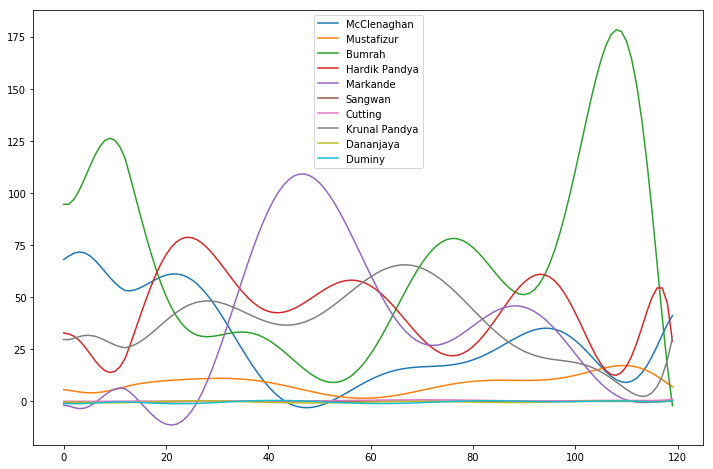

In [319]:
plt.figure(figsize=(12,8))
team = "Mumbai Indians"
"""
batsman_list = dfi[dfi["batting_team"]==team]["batsman"]
for batsman in batsman_list:
    dft = dfi[dfi["batsman"]==batsman]
    dfis = dft[[i for i in range(120)]] * dft["bat_venue"].values[0]
    plt.plot(range(120), np.asarray(dfis[[i for i in range(120)]]).T)
plt.legend(batsman_list)
"""

plt.figure(figsize=(12,8))
bowler_list = dfi_ball[dfi_ball["team"]==team]["bowler"]
for bowler in bowler_list:
    dft = dfi_ball[dfi_ball["bowler"]==bowler]
    dfis = dft[[i for i in range(120)]] #* dft["bowl_venue"].values[0]
    plt.plot(range(120), np.asarray(dfis[[i for i in range(120)]]).T)
    
plt.legend(bowler_list)

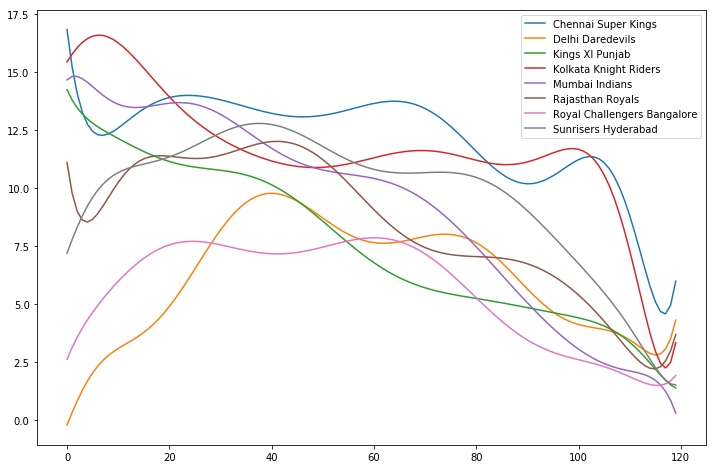

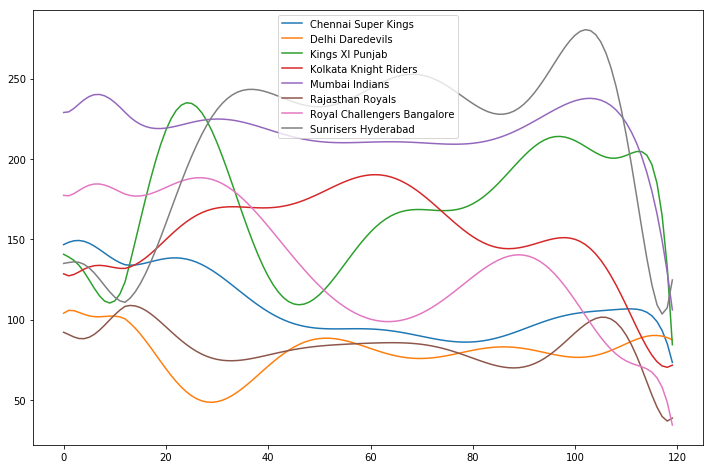

In [312]:
dfit = dfi[dfi["runs_scored"]>=250].copy()
del dfit["bat_venue"], dfit["runs_scored"]
dfit = dfit.groupby("batting_team").sum().reset_index()
plt.figure(figsize=(12,8))
#for t in dfit["batting_team"]:
plt.plot(range(120), np.asarray(dfit[[i for i in range(120)]]).T)
plt.legend(dfit["batting_team"])
#dfit

dfit = dfi_ball[dfi_ball["wickets"]>=6].copy()
#del dfit["bowl_venue"], dfit["wickets"]
dfit = dfit.groupby("team").sum().reset_index()
plt.figure(figsize=(12,8))
#for t in dfit["batting_team"]:
plt.plot(range(120), np.asarray(dfit[[i for i in range(120)]]).T)
plt.legend(dfit["team"])
#dfit